In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


In [51]:
df = pd.read_csv("diabetes.csv")
print(df.head())
print(df.info())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

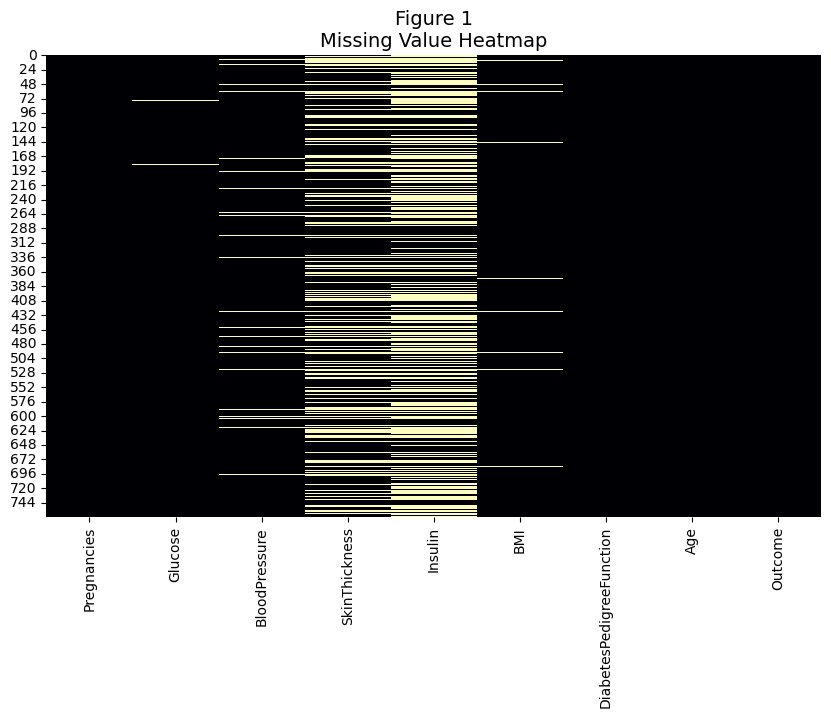

In [52]:
# Replace physiologically impossible zero values with NaN
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="magma")
plt.title("Figure 1\nMissing Value Heatmap", fontsize=14)
plt.show()


In [53]:
df.fillna(df.median(), inplace=True)


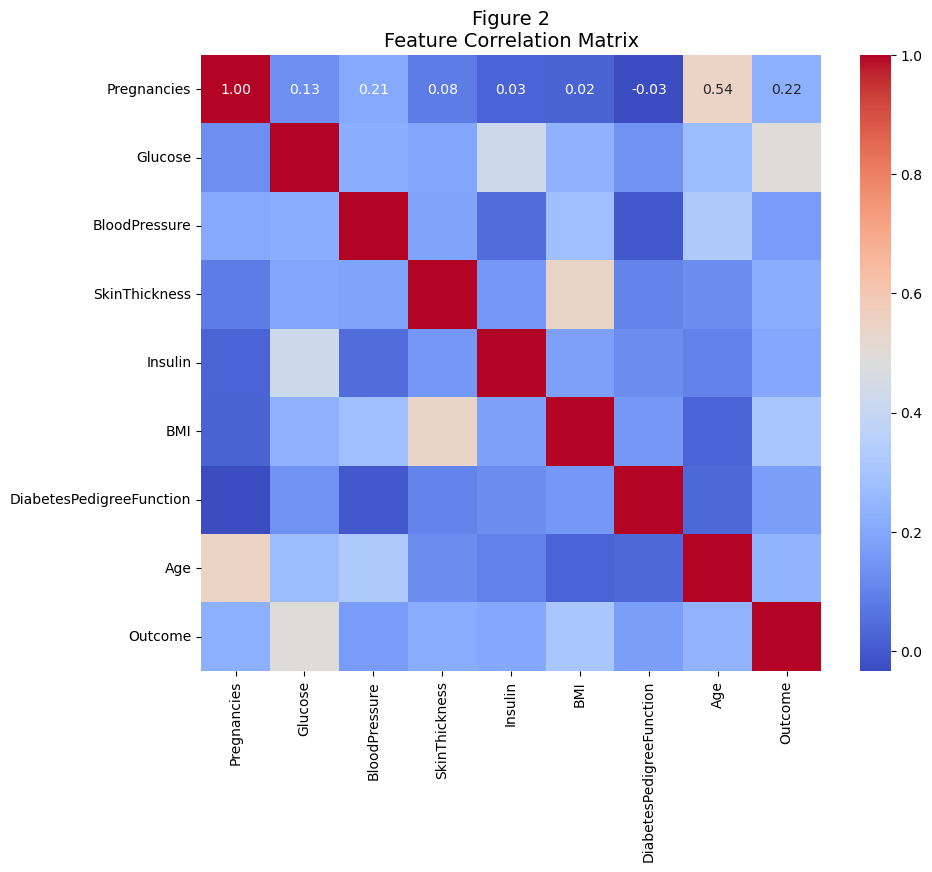

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Figure 2\nFeature Correlation Matrix", fontsize=14)
plt.show()


C:\Users\cheli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


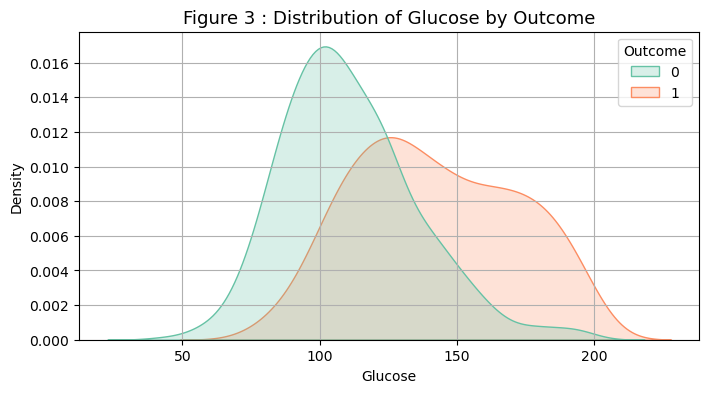

C:\Users\cheli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


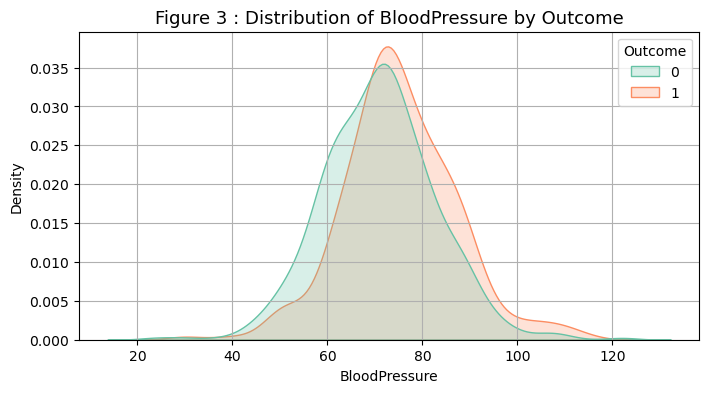

C:\Users\cheli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


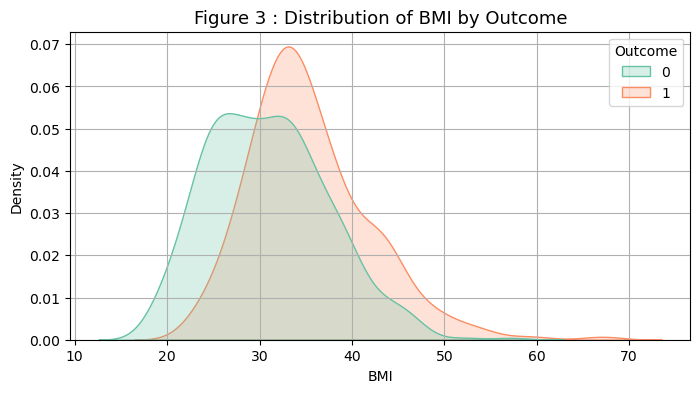

C:\Users\cheli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


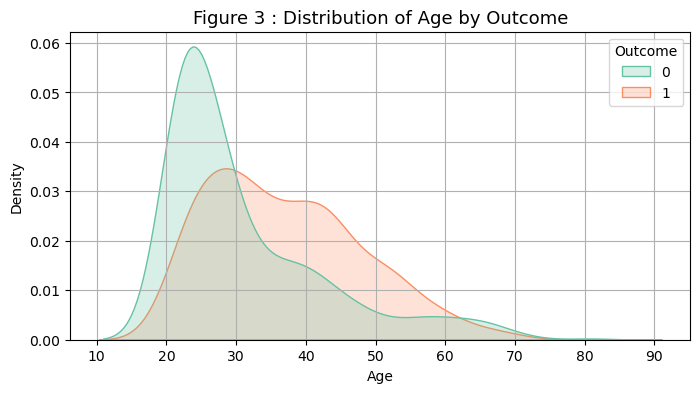

In [55]:
features = ['Glucose', 'BloodPressure', 'BMI', 'Age']
for col in features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=col, hue='Outcome', fill=True, common_norm=False, palette='Set2')
    plt.title(f"Figure 3 : Distribution of {col} by Outcome", fontsize=13)
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


In [56]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [57]:
svm = SVC(probability=True)
param_svm = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
grid_svm = GridSearchCV(svm, param_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)
svm_best = grid_svm.best_estimator_


In [58]:
gbm = GradientBoostingClassifier()
param_gbm = {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
grid_gbm = GridSearchCV(gbm, param_gbm, cv=5, scoring='accuracy')
grid_gbm.fit(X_train, y_train)
gbm_best = grid_gbm.best_estimator_


In [59]:
rf = RandomForestClassifier(random_state=42)
param_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
rf_best = grid_rf.best_estimator_


In [60]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc:.4f}\n")
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC-ROC": auc
    }


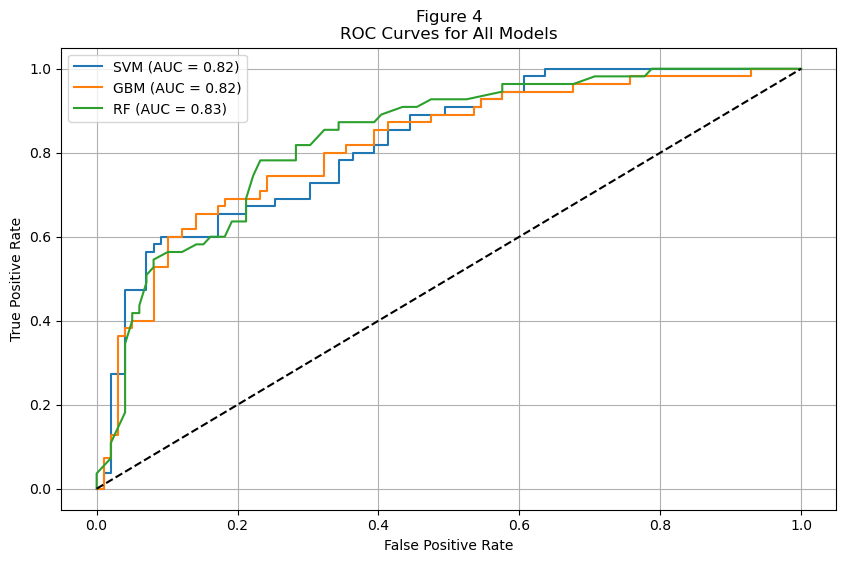

In [61]:
plt.figure(figsize=(10,6))

for name, model, X in [
    ("SVM", svm_best, X_test_scaled),
    ("GBM", gbm_best, X_test),
    ("RF", rf_best, X_test)
]:
    y_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 4\nROC Curves for All Models')
plt.legend()
plt.grid(True)
plt.show()


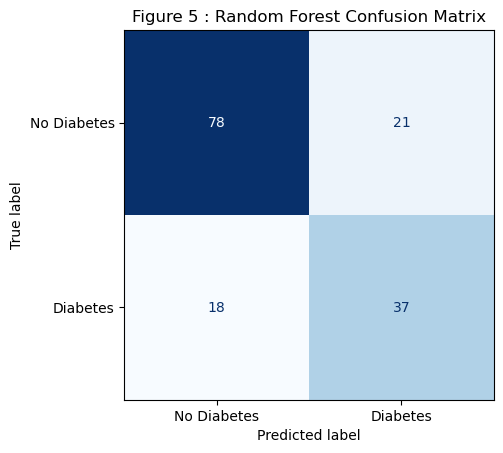

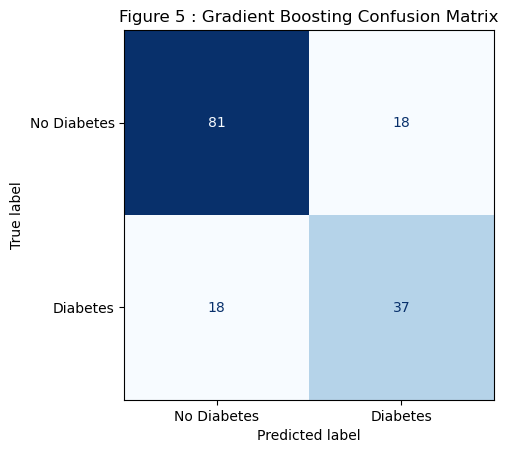

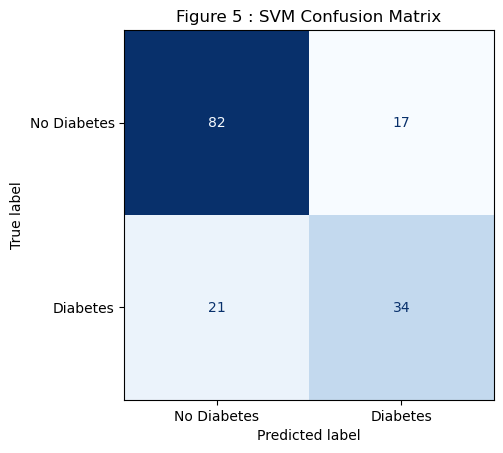

In [63]:
def plot_conf_matrix(model, X_test, y_test, title):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test,
        display_labels=["No Diabetes", "Diabetes"],
        cmap='Blues',
        colorbar=False
    )
    plt.title(f"Figure 5 : {title}")
    plt.grid(False)
    plt.show()

plot_conf_matrix(rf_best, X_test, y_test, "Random Forest Confusion Matrix")
plot_conf_matrix(gbm_best, X_test, y_test, "Gradient Boosting Confusion Matrix")
plot_conf_matrix(svm_best, X_test_scaled, y_test, "SVM Confusion Matrix")


In [46]:
# Re-evaluate and store metrics
results = []
results.append(evaluate_model("SVM", svm_best, X_test_scaled, y_test))
results.append(evaluate_model("Gradient Boosting", gbm_best, X_test, y_test))
results.append(evaluate_model("Random Forest", rf_best, X_test, y_test))

# Create comparison table
results_df = pd.DataFrame(results)

# Display APA-style labeled summary
print("\nTable 1\nModel Comparison Summary\n")
print(results_df.round(4))


Model: SVM
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

AUC-ROC: 0.8217

Model: Gradient Boosting
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        99
           1       0.67      0.67      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154

AUC-ROC: 0.8176

Model: Random Forest
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        99
           1       0.64      0.67      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73    

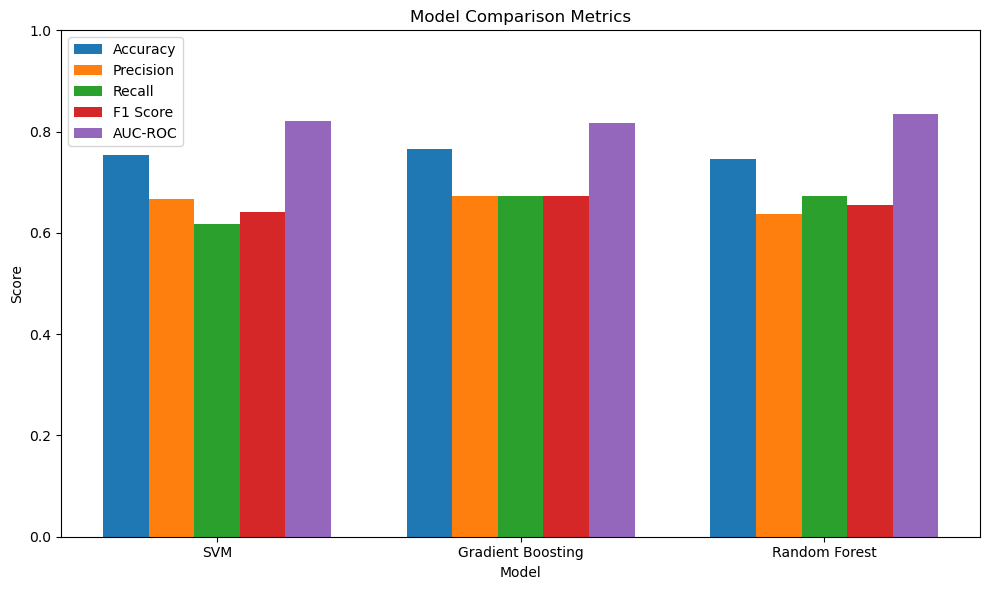

In [64]:

# Your data
data = {
    'Model': ['SVM', 'Gradient Boosting', 'Random Forest'],
    'Accuracy': [0.7532, 0.7662, 0.7468],
    'Precision': [0.6667, 0.6727, 0.6379],
    'Recall': [0.6182, 0.6727, 0.6727],
    'F1 Score': [0.6415, 0.6727, 0.6549],
    'AUC-ROC': [0.8217, 0.8169, 0.8340]
}

df = pd.DataFrame(data)

# Set the position of the bars on the x-axis
bar_width = 0.15
index = np.arange(len(df['Model']))

# Plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot each metric
ax.bar(index - 2*bar_width, df['Accuracy'], width=bar_width, label='Accuracy')
ax.bar(index - bar_width, df['Precision'], width=bar_width, label='Precision')
ax.bar(index, df['Recall'], width=bar_width, label='Recall')
ax.bar(index + bar_width, df['F1 Score'], width=bar_width, label='F1 Score')
ax.bar(index + 2*bar_width, df['AUC-ROC'], width=bar_width, label='AUC-ROC')

# Labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison Metrics')
ax.set_xticks(index)
ax.set_xticklabels(df['Model'])
ax.set_ylim(0, 1)  # Since all metrics are between 0 and 1

ax.legend()
plt.tight_layout()
plt.show()

In [65]:
# Create the summary table data
data = {
    'Model': ['SVM', 'Gradient Boosting', 'Random Forest'],
    'Accuracy': [0.7532, 0.7662, 0.7468],
    'Precision': [0.6667, 0.6727, 0.6379],
    'Recall': [0.6182, 0.6727, 0.6727],
    'F1 Score': [0.6415, 0.6727, 0.6549],
    'AUC-ROC': [0.8217, 0.8169, 0.8340]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the summary table
print("Model Comparison Summary Table:\n")
print(df.to_string(index=False))

Model Comparison Summary Table:

            Model  Accuracy  Precision  Recall  F1 Score  AUC-ROC
              SVM    0.7532     0.6667  0.6182    0.6415   0.8217
Gradient Boosting    0.7662     0.6727  0.6727    0.6727   0.8169
    Random Forest    0.7468     0.6379  0.6727    0.6549   0.8340


## Reflection

Reflection:

Among the three models evaluated, Gradient Boosting demonstrated the best overall balance, achieving the highest accuracy (0.7662) and leading in precision, recall, and F1 score. This suggests that Gradient Boosting was more effective in correctly identifying both positive and negative classes while maintaining a good trade-off between precision and recall.

Although Random Forest achieved the highest AUC-ROC (0.8340), indicating strong discriminatory power between classes, its accuracy and precision were slightly lower than Gradient Boosting. This might suggest Random Forest is better at ranking predictions but less optimal in strict classification decisions based on the current threshold.

The SVM model performed competitively, particularly in AUC-ROC (0.8217), but it lagged behind in recall and F1 score, which could indicate it missed some positive cases.

Hyperparameter tuning played a significant role in optimizing these models. For example, fine-tuning learning rates and the number of estimators in Gradient Boosting helped improve both recall and precision, leading to better F1 scores. Similarly, adjusting the number of trees and depth in Random Forest affected its ability to generalize, reflected in the balance of accuracy and AUC-ROC.

In conclusion, Gradient Boosting was the best-performing model on this dataset due to its consistent performance across multiple metrics, indicating robustness in handling the classification task.
